<a href="https://colab.research.google.com/github/AchmadMuafiTaufiqurrochman/KNN-Dummy-UTS-Visi-Komputer/blob/main/KNN_Dummy_UTS_Visi_Komputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Akurasi: 1.0

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



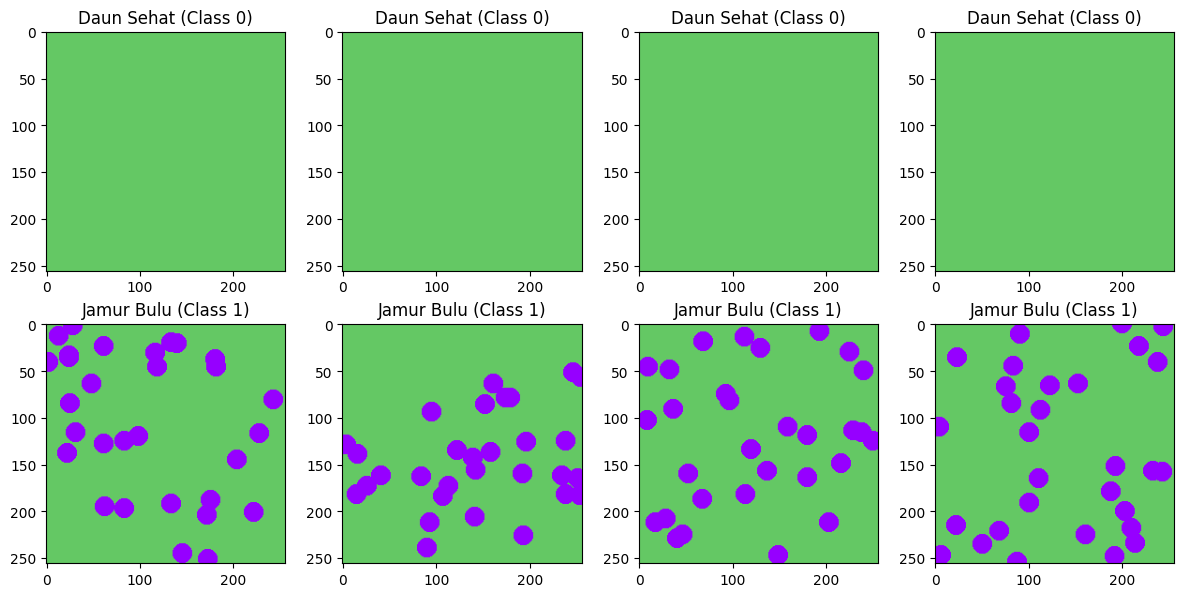

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage import io, transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFilter

# =============================================================================
# FUNGSI PEMBUATAN GAMBAR DUMMY
# =============================================================================
def generate_dummy_images():
    classes = ['healthy', 'downy_mildew', 'rust', 'powdery_mildew']
    images = []
    labels = []

    # Daun Sehat (Hijau solid)
    for _ in range(10):
        img = Image.new('RGB', (256, 256), (100, 200, 100))
        images.append(np.array(img))
        labels.append(0)

    # Jamur Bulu (Downy Mildew - Bercak ungu)
    for _ in range(10):
        img = Image.new('RGB', (256, 256), (100, 200, 100))
        draw = ImageDraw.Draw(img)
        for _ in range(30):
            x, y = np.random.randint(0, 256, 2)
            draw.ellipse([x-10, y-10, x+10, y+10], fill=(150, 0, 255))
        images.append(np.array(img))
        labels.append(1)

    # Jamur Karat (Rust - Bercak coklat)
    for _ in range(10):
        img = Image.new('RGB', (256, 256), (100, 200, 100))
        draw = ImageDraw.Draw(img)
        for _ in range(30):
            x, y = np.random.randint(0, 256, 2)
            draw.ellipse([x-10, y-10, x+10, y+10], fill=(128, 64, 0))
        images.append(np.array(img))
        labels.append(2)

    # Jamur Tepung (Powdery Mildew - Bercak putih)
    for _ in range(10):
        img = Image.new('RGB', (256, 256), (100, 200, 100))
        draw = ImageDraw.Draw(img)
        for _ in range(30):
            x, y = np.random.randint(0, 256, 2)
            draw.ellipse([x-10, y-10, x+10, y+10], fill=(255, 255, 255))
        images.append(np.array(img))
        labels.append(3)

    return np.array(images), np.array(labels)

# =============================================================================
# FUNGSI EKSTRAKSI FITUR
# =============================================================================
def extract_features(image):
    # Resize ke 64x64 (sesuai paper)
    resized = cv2.resize(image, (64, 64))

    # Konversi ke grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)

    # Ekstraksi fitur LBP (Local Binary Pattern)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist = np.histogram(lbp.ravel(), bins=256, range=(0, 256))[0]

    # Ekstraksi fitur morfologi (Canny + Hu Moments)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        cnt = max(contours, key=cv2.contourArea)
        hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()
    else:
        hu_moments = np.zeros(7)

    # Ekstraksi fitur warna (HSV Histogram)
    hsv = cv2.cvtColor(resized, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [180], [0, 180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [256], [0, 256]).flatten()
    hist_v = cv2.calcHist([hsv], [2], None, [256], [0, 256]).flatten()

    # Gabungkan semua fitur
    features = np.concatenate([lbp_hist, hu_moments, hist_h, hist_s, hist_v])
    return features

# =============================================================================
# UTAMA
# =============================================================================
# 1. Buat gambar dummy
images, labels = generate_dummy_images()

# 2. Ekstraksi fitur semua gambar
features = []
for img in images:
    features.append(extract_features(img))
features = np.array(features)

# 3. Pecah data (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# 4. Latih model KNN dengan K=1 (optimal berdasar paper)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# 5. Evaluasi
y_pred = knn.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# =============================================================================
# VISUALISASI DUMMY
# =============================================================================
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Daun Sehat (Class {labels[i]})")

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.imshow(images[10+i])
    plt.title(f"Jamur Bulu (Class {labels[10+i]})")

plt.tight_layout()
plt.show()